In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.anova import anova_lm
%matplotlib inline
plt.rcParams['figure.figsize']=10,10
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Motivation
Observing that many individuals allocate their financial resources to BIST100 in an attempt to alleviate the effects of rising inflation, I wanted to investigate this idea statistically. In addition to inflation, unemployment too may have an effect on the stock market. This notebook will attempt to reveal possible relationships through regression analysis. 

About the data:
The data spans the years from 1998-2022, because within this range all variables were recorded properly. Inflation is based on consumer prices and is in percentages. Unemployment is the percentage of workforce who are currently unemployed. BIST100 yearly average closing prices were used. Unemployment and inflation variables were obtained from World Bank Open Data, and BIST100 yearly average closing prices were obtained from Yahoo Finance. I took averages manually and did other minor data wrangling by hand because it was small enough to make using Python unnecessary. Also, I am a masochist and enjoy hurting myself by using Microsoft Excel.

NOTES:
I will, at first, treat the observations as if they are independent but probably there is a serial dependence. 

These variables are about Turkey because at this point I reside in Turkey.

# Loading the Dataset

In [2]:
unemployment_stocks_inflation = pd.read_excel(r"C:\Users\kagan\OneDrive\Masaüstü\DATA\Unemployment-BIST100-Inflation Dataset\unemployment-inflation-stockmarket-yearly.xlsx")
# Give head
unemployment_stocks_inflation 

,YEAR,INFLATION,UNEMPLOYMENT,BIST100AVGCLOSE
0,1998,84.641343,6.55,3.224658
1,1999,64.867488,7.45,6.125483
2,2000,54.915371,6.30,14.044592
3,2001,54.400189,8.37,10.386308
4,2002,44.964121,10.35,10.814225
5,2003,21.602438,10.55,12.507817
6,2004,85.982617,10.83,20.110108
7,2005,81.791604,10.63,30.063058
8,2006,95.972421,8.72,40.010858
9,2007,87.561809,8.87,49.155809


# Plots

## All variable pairs

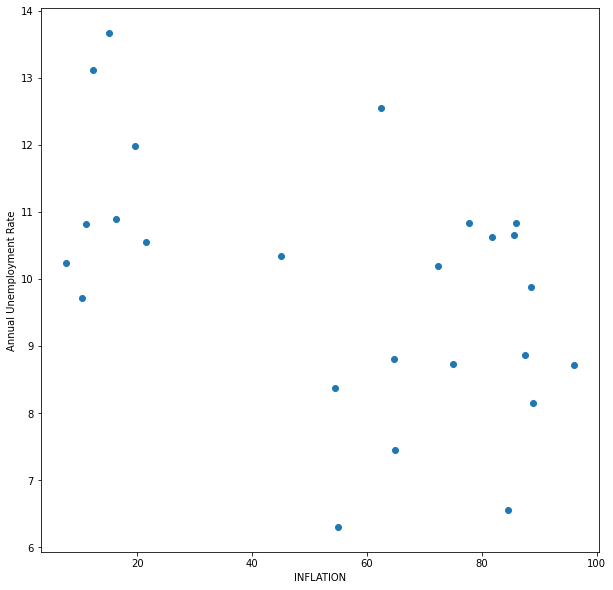

In [3]:
_ = plt.scatter(unemployment_stocks_inflation["INFLATION"], unemployment_stocks_inflation["UNEMPLOYMENT"])
_ = plt.xlabel("INFLATION")
_ = plt.ylabel("Annual Unemployment Rate")

Despite the fact that the data is diagonally spread to a considerable degree, it is obvious that there is an inverse relationship between inflation and unemployment rate. As inflation increases, unemployment tends to decrease. This is consistent with economic theory, this relationship is known as the Phillips curve.

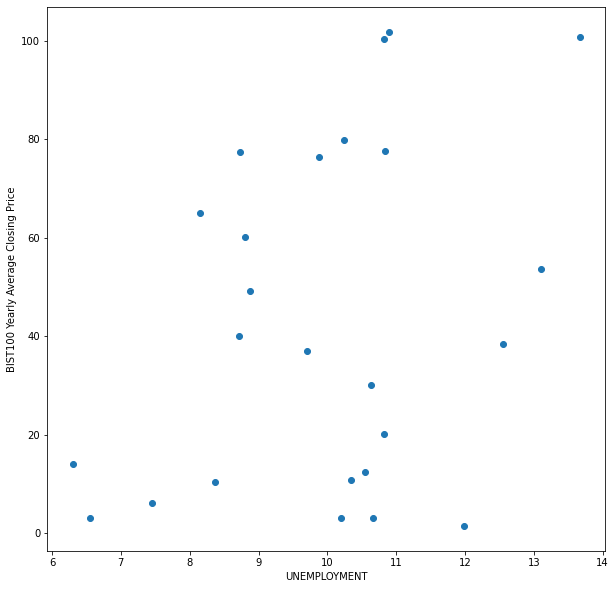

In [4]:
_ = plt.scatter(unemployment_stocks_inflation["UNEMPLOYMENT"], unemployment_stocks_inflation["BIST100AVGCLOSE"])
_ = plt.xlabel("UNEMPLOYMENT")
_ = plt.ylabel("BIST100 Yearly Average Closing Price")

This is an interesting pattern- there appears to be a direct relationship between unemployment and stock prices. As unemployment increases, stock prices tend to increase as well. This is an interesting an known relationship. As the unemployment rate increases, the Central Bank (of an arbitrary country) tends to lower the interest rates, which in turn increases stock market prices (though other effects may attenuate this). For more information, 
https://ideas.repec.org/p/cte/werepe/24120.html

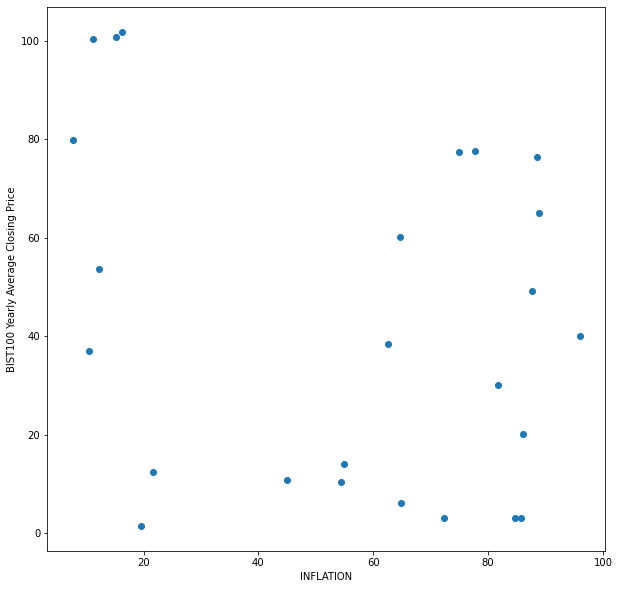

In [5]:
_ = plt.scatter(unemployment_stocks_inflation["INFLATION"], unemployment_stocks_inflation["BIST100AVGCLOSE"])
_ = plt.xlabel("INFLATION")
_ = plt.ylabel("BIST100 Yearly Average Closing Price")

There is no clear linear relationship between inflation and yearly average stock closing prices. However, a line that separates these pairs into two distinct groups can be made. Upon a closer examination, it can be seen that after inflation rises above 20%, a considerable linear relationship forms between these two variables. This suggests the use of a dummy variable in regression, that marks whether inflation is above or below 20%.  

In [6]:
# Adding dummy variables
unemployment_stocks_inflation["Inflation_above_20_percent"] = unemployment_stocks_inflation["INFLATION"].apply(lambda x: 1 if x >= 20 else 0)
unemployment_stocks_inflation["Inflation_below_20_percent"] = unemployment_stocks_inflation["INFLATION"].apply(lambda x: 1 if x <  20 else 0)
unemployment_stocks_inflation

,YEAR,INFLATION,UNEMPLOYMENT,BIST100AVGCLOSE,Inflation_above_20_percent,Inflation_below_20_percent
0,1998,84.641343,6.55,3.224658,1,0
1,1999,64.867488,7.45,6.125483,1,0
2,2000,54.915371,6.30,14.044592,1,0
3,2001,54.400189,8.37,10.386308,1,0
4,2002,44.964121,10.35,10.814225,1,0
5,2003,21.602438,10.55,12.507817,1,0
6,2004,85.982617,10.83,20.110108,1,0
7,2005,81.791604,10.63,30.063058,1,0
8,2006,95.972421,8.72,40.010858,1,0
9,2007,87.561809,8.87,49.155809,1,0


## All variables through time

Let's observe how these variables change through time, once without log transform, and once with. 

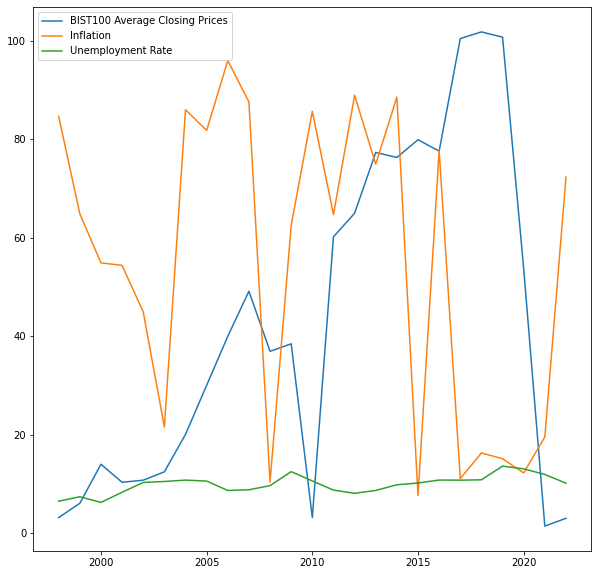

In [7]:
_ = plt.plot(unemployment_stocks_inflation["YEAR"], unemployment_stocks_inflation["BIST100AVGCLOSE"], label = "BIST100 Average Closing Prices")
_ = plt.plot(unemployment_stocks_inflation["YEAR"], unemployment_stocks_inflation["INFLATION"], label = "Inflation")
_ = plt.plot(unemployment_stocks_inflation["YEAR"], unemployment_stocks_inflation["UNEMPLOYMENT"], label = "Unemployment Rate")
_ = plt.legend(loc = "upper left")

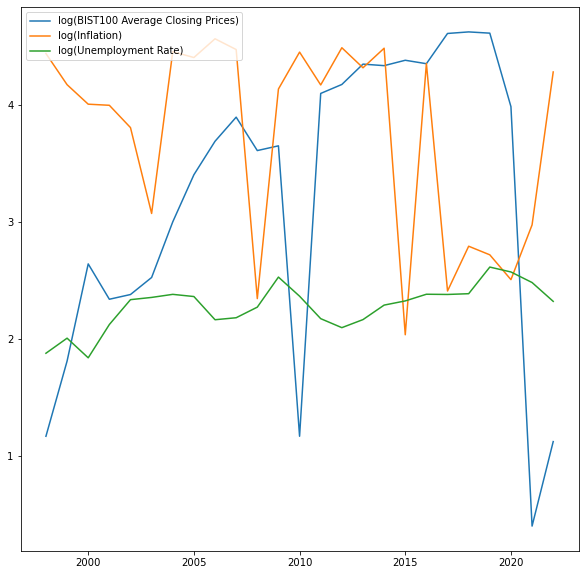

In [8]:
_ = plt.plot(unemployment_stocks_inflation["YEAR"], np.log(unemployment_stocks_inflation["BIST100AVGCLOSE"]), label = "log(BIST100 Average Closing Prices)")
_ = plt.plot(unemployment_stocks_inflation["YEAR"], np.log(unemployment_stocks_inflation["INFLATION"]), label = "log(Inflation)")
_ = plt.plot(unemployment_stocks_inflation["YEAR"], np.log(unemployment_stocks_inflation["UNEMPLOYMENT"]), label = "log(Unemployment Rate)")
_ = plt.legend(loc = "upper left")

These relationships will be better explained through regression.

# Multicollinearity checks

There are different ways to assess multicollinearity and partial regressions can be very sensitive. However, this method is harder to interpret and a little more time consuming, so I will assess multicollinearity through correlation matrix in this study. 

In [9]:
unemployment_stocks_inflation.corr()

,YEAR,INFLATION,UNEMPLOYMENT,BIST100AVGCLOSE,Inflation_above_20_percent,Inflation_below_20_percent
YEAR,1.000000,-0.372027,0.646694,0.560645,-0.592999,0.592999
INFLATION,-0.372027,1.000000,-0.471220,-0.277472,0.857477,-0.857477
UNEMPLOYMENT,0.646694,-0.471220,1.000000,0.315446,-0.528509,0.528509
BIST100AVGCLOSE,0.560645,-0.277472,0.315446,1.000000,-0.462371,0.462371
Inflation_above_20_percent,-0.592999,0.857477,-0.528509,-0.462371,1.000000,-1.000000
Inflation_below_20_percent,0.592999,-0.857477,0.528509,0.462371,-1.000000,1.000000


With the exception of our dummy variable, explanatory variables unemployment and inflation do not show a considerable correlation, so they can be used together as explanatory variables. 

# Models

There are multiple plausible models to consider here, first being the straightforward

$$BIST100AVGCLOSE  =  m + UNEMPLOYMENT + INFLATION$$.

Including a constant parameter makes sense because there will be a baseline stock price if none of unemployment and inflation have any effect. The interaction of unemployment and inflation may affect stock prices, so another model could be

$$BIST100AVGCLOSE  =  m + UNEMPLOYMENT + INFLATION + UNEMPLOYMENT * INFLATION$$.

Other two models will be attempts to predict BIST100AVGCLOSE using dummy variables which fit two different lines based on whether the inflation value is above or below 40 percent, one considering unemployment and other not considering unemployment. 

$$BIST100AVGCLOSE  =  m + UNEMPLOYMENT + INFLATION * INFLATION ABOVE 20 PERCENT + INFLATION * INFLATION BELOW 20 PERCENT+ INFLATION * INFLATION BELOW 20 PERCENT$$.
$$BIST100AVGCLOSE  =  m + INFLATION * NFLATION ABOVE 40 PERCENT + INFLATION * INFLATION ABOVE 20 PERCENT+ INFLATION * INFLATION BELOW 20 PERCENT$$.

The results of these models are below. As the timeline is too short for Box-Jenkins framework of time series modeling, they will not be of consideration here.

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Model 1

In [11]:
model_1 = smf.ols(formula = "BIST100AVGCLOSE ~ INFLATION + UNEMPLOYMENT", data = unemployment_stocks_inflation).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        BIST100AVGCLOSE   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     1.512
Date:                Thu, 14 Sep 2023   Prob (F-statistic):              0.243
Time:                        11:06:55   Log-Likelihood:                -121.77
No. Observations:                  25   AIC:                             249.5
Df Residuals:                      22   BIC:                             253.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        9.0457     50.389      0.180      0.859     -95.454     113.546
INFLATION       -0.1818      0.249     -0.731      0.473      -0.698       0.334
UNEMPLOYMENT     4.4135      4.213      1.048      0.306      -4.324      13.151
==============================================================================
Omnibus:                        7.230   Durbin-Watson:                   0.472
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                1.954
Skew:                           0.080   Prob(JB):                        0.376
Kurtosis:                       1.640   Cond. No.                         480.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
anova_lm(model_1)

,df,sum_sq,mean_sq,F,PR(>F)
INFLATION,1.0,2180.895290,2180.895290,1.926601,0.179028
UNEMPLOYMENT,1.0,1242.107554,1242.107554,1.097277,0.306237
Residual,22.0,24903.808360,1131.991289,NaN,NaN


In [13]:
model_1.mse_resid

1131.991289086263

R-squared values, lack of statistically significant parameter estimates and overall low P(F statistic) shows that this naive model is insignificant.

## Model 2

In [14]:
model_2 = smf.ols(formula = "BIST100AVGCLOSE ~ INFLATION + UNEMPLOYMENT + INFLATION * UNEMPLOYMENT", data = unemployment_stocks_inflation).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        BIST100AVGCLOSE   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.223
Date:                Thu, 14 Sep 2023   Prob (F-statistic):              0.326
Time:                        11:06:55   Log-Likelihood:                -121.37
No. Observations:                  25   AIC:                             250.7
Df Residuals:                      21   BIC:                             255.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -66.6617    104.468     -0.638      0.530    -283.915     150.591
INFLATION                  1.1696      1.649      0.709      0.486      -2.260       4.599
UNEMPLOYMENT              11.3463      9.377      1.210      0.240      -8.154      30.847
INFLATION:UNEMPLOYMENT    -0.1298      0.157     -0.829      0.416      -0.455       0.196
==============================================================================
Omnibus:                        4.086   Durbin-Watson:                   0.443
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                1.528
Skew:                           0.080   Prob(JB):                        0.466
Kurtosis:                       1.800   Cond. No.                     9.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
anova_lm(model_2)

,df,sum_sq,mean_sq,F,PR(>F)
INFLATION,1.0,2180.895290,2180.895290,1.899227,0.182673
UNEMPLOYMENT,1.0,1242.107554,1242.107554,1.081686,0.310148
INFLATION:UNEMPLOYMENT,1.0,789.360805,789.360805,0.687413,0.416371
Residual,21.0,24114.447555,1148.307026,NaN,NaN


In [16]:
model_2.mse_resid

1148.3070264262637

Including the interaction of unemployment and inflation did not improve the performance of the model, in fact, it increased the mean squared error in residuals. Still, no parameters are statistically significant.

## Model 3

In [17]:
model_3 = smf.ols(formula = "BIST100AVGCLOSE ~ UNEMPLOYMENT + INFLATION * Inflation_above_20_percent + INFLATION * Inflation_below_20_percent", data = unemployment_stocks_inflation).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        BIST100AVGCLOSE   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     2.463
Date:                Thu, 14 Sep 2023   Prob (F-statistic):             0.0784
Time:                        11:06:55   Log-Likelihood:                -118.38
No. Observations:                  25   AIC:                             246.8
Df Residuals:                      20   BIC:                             252.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               12.8355     31.334      0.410      0.686     -52.527      78.198
UNEMPLOYMENT                             3.2736      4.126      0.793      0.437      -5.334      11.881
INFLATION                               -0.9854      1.072     -0.919      0.369      -3.221       1.251
Inflation_above_20_percent             -51.2703     28.158     -1.821      0.084    -110.006       7.466
INFLATION:Inflation_above_20_percent     1.5567      1.102      1.412      0.173      -0.742       3.856
Inflation_below_20_percent              64.1058     32.325      1.983      0.061      -3.324     131.535
INFLATION:Inflation_below_20_percent    -2.5421      2.138     -1.189      0.248      -7.002       1.918
==============================================================================
Omnibus:                        3.724   Durbin-Watson:                   1.072
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                1.499
Skew:                           0.131   Prob(JB):                        0.473
Kurtosis:                       1.829   Cond. No.                     1.16e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.48e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
anova_lm(model_3)

,df,sum_sq,mean_sq,F,PR(>F)
UNEMPLOYMENT,1.0,2818.693249,2818.693249,2.970275,0.100234
INFLATION,1.0,604.309595,604.309595,0.636808,0.434243
Inflation_above_20_percent,1.0,4395.069092,4395.069092,4.631425,0.043786
INFLATION:Inflation_above_20_percent,1.0,1529.399124,1529.399124,1.611646,0.218835
Inflation_below_20_percent,1.0,985.801616,985.801616,1.038815,0.320269
INFLATION:Inflation_below_20_percent,1.0,0.699099,0.699099,0.000737,0.978615
Residual,20.0,18979.340145,948.967007,NaN,NaN


In [19]:
model_3.mse_resid

948.9670072372331

Splitting the explanatory variables into two parameters through dummy variables improved model performance in terms of R-squared and model error. Interestingly, dummy variables are statistically significant. 

## Model 4

In [20]:
model_4 = smf.ols(formula = "BIST100AVGCLOSE ~ INFLATION * Inflation_above_20_percent + INFLATION * Inflation_below_20_percent", data = unemployment_stocks_inflation).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        BIST100AVGCLOSE   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     3.129
Date:                Thu, 14 Sep 2023   Prob (F-statistic):             0.0474
Time:                        11:06:55   Log-Likelihood:                -118.76
No. Observations:                  25   AIC:                             245.5
Df Residuals:                      21   BIC:                             250.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               33.5756     17.121      1.961      0.063      -2.028      69.180
INFLATION                               -0.8004      1.037     -0.772      0.449      -2.957       1.356
Inflation_above_20_percent             -39.7551     23.914     -1.662      0.111     -89.488       9.978
INFLATION:Inflation_above_20_percent     1.3491      1.061      1.271      0.218      -0.858       3.556
Inflation_below_20_percent              73.3308     29.894      2.453      0.023      11.162     135.499
INFLATION:Inflation_below_20_percent    -2.1495      2.062     -1.043      0.309      -6.437       2.138
==============================================================================
Omnibus:                        4.139   Durbin-Watson:                   1.136
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                1.544
Skew:                           0.094   Prob(JB):                        0.462
Kurtosis:                       1.797   Cond. No.                     1.22e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.32e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [21]:
anova_lm(model_4)

,df,sum_sq,mean_sq,F,PR(>F)
INFLATION,1.0,2180.895290,2180.895290,2.339467,0.141057
Inflation_above_20_percent,1.0,5390.292769,5390.292769,5.782218,0.025496
INFLATION:Inflation_above_20_percent,1.0,1179.027030,1179.027030,1.264753,0.273444
Inflation_below_20_percent,1.0,1248.907546,1248.907546,1.339715,0.260080
INFLATION:Inflation_below_20_percent,1.0,2404.914015,2404.914015,2.579774,0.123170
Residual,21.0,19576.596115,932.218863,NaN,NaN


In [22]:
model_4.mse_resid

932.2188626111082

This model shows improvements. Usually, adding new explanatory variables improves model performance, but this time, dropping unemployment data seems to have worked. 

## Adding first lag of response variable

In [23]:
unemployment_stocks_inflation["BIST100_lag1"] = unemployment_stocks_inflation["BIST100AVGCLOSE"].shift()
unemployment_stocks_inflation = unemployment_stocks_inflation.dropna()

In [24]:
unemployment_stocks_inflation

,YEAR,INFLATION,UNEMPLOYMENT,BIST100AVGCLOSE,Inflation_above_20_percent,Inflation_below_20_percent,BIST100_lag1
1,1999,64.867488,7.45,6.125483,1,0,3.224658
2,2000,54.915371,6.30,14.044592,1,0,6.125483
3,2001,54.400189,8.37,10.386308,1,0,14.044592
4,2002,44.964121,10.35,10.814225,1,0,10.386308
5,2003,21.602438,10.55,12.507817,1,0,10.814225
6,2004,85.982617,10.83,20.110108,1,0,12.507817
7,2005,81.791604,10.63,30.063058,1,0,20.110108
8,2006,95.972421,8.72,40.010858,1,0,30.063058
9,2007,87.561809,8.87,49.155809,1,0,40.010858
10,2008,10.444128,9.71,36.960475,0,1,49.155809


## Model 5

In [25]:
model_5 = smf.ols(formula = "BIST100AVGCLOSE ~ INFLATION * Inflation_above_20_percent + INFLATION * Inflation_below_20_percent + UNEMPLOYMENT + INFLATION * UNEMPLOYMENT + BIST100_lag1 ", data = unemployment_stocks_inflation).fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        BIST100AVGCLOSE   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     7.018
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           0.000692
Time:                        11:06:55   Log-Likelihood:                -103.27
No. Observations:                  24   AIC:                             220.5
Df Residuals:                      17   BIC:                             228.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               31.0880     52.152      0.596      0.559     -78.943     141.119
INFLATION                               -0.8666      0.963     -0.900      0.381      -2.898       1.165
Inflation_above_20_percent               4.9362     35.824      0.138      0.892     -70.646      80.518
INFLATION:Inflation_above_20_percent     0.9009      1.063      0.847      0.409      -1.342       3.144
Inflation_below_20_percent              26.1518     31.005      0.843      0.411     -39.263      91.567
INFLATION:Inflation_below_20_percent    -1.7675      1.490     -1.186      0.252      -4.911       1.376
UNEMPLOYMENT                            -2.8410      8.105     -0.351      0.730     -19.941      14.259
INFLATION:UNEMPLOYMENT                  -0.0093      0.132     -0.070      0.945      -0.288       0.269
BIST100_lag1                             0.9950      0.220      4.527      0.000       0.531       1.459
==============================================================================
Omnibus:                        3.570   Durbin-Watson:                   2.251
Prob(Omnibus):                  0.168   Jarque-Bera (JB):                1.856
Skew:                           0.477   Prob(JB):                        0.395
Kurtosis:                       3.973   Cond. No.                     2.81e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.13e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [26]:
anova_lm(model_5)

,df,sum_sq,mean_sq,F,PR(>F)
INFLATION,1.0,1565.707239,1565.707239,3.467838,0.079950
Inflation_above_20_percent,1.0,5802.740308,5802.740308,12.852315,0.002282
INFLATION:Inflation_above_20_percent,1.0,1236.302465,1236.302465,2.738249,0.116315
Inflation_below_20_percent,1.0,694.628467,694.628467,1.538512,0.231687
INFLATION:Inflation_below_20_percent,1.0,411.330095,411.330095,0.911043,0.353214
UNEMPLOYMENT,1.0,38.428219,38.428219,0.085114,0.774014
INFLATION:UNEMPLOYMENT,1.0,1300.158064,1300.158064,2.879681,0.107935
BIST100_lag1,1.0,8580.551795,8580.551795,19.004807,0.000427
Residual,17.0,7675.394009,451.493765,NaN,NaN


Inflation, the interaction between unemployment and inflation and the lagged values account for much of the variance in the model. 

In [27]:
model_5.mse_resid

451.4937652122986

Mean squared error is the lowest among all models.

This is, by far, the best model. This is primarily because the data are taken from a time series process, but ARMA models would not be sufficient because of small sample size. I overcame this problem here. Furthermore, the serial correlation in errors were handled (see the DW statistic close to 2). 
An important thing to notice, however, is that no variable besides first lag of the series is statistically significant. Nevertheless, the model is statistically significant, as evidenced by the p-value. We should save the residuals of this model and conduct an analysis on residuals.

# Residual analysis

In [28]:
residuals = model_5.resid

## Heteroskedasticity
Heteroskedasticity often arises in time series data, so it is better to check whether it is present in residuals.

In [29]:
from statsmodels.stats.diagnostic import het_white

model_resid_var = np.square(residuals)

explanatory_variables = ["INFLATION", "UNEMPLOYMENT", "BIST100_lag1", "Inflation_above_20_percent"]
het_test_white = het_white(model_resid_var, sm.add_constant(unemployment_stocks_inflation[explanatory_variables]))[3]

print("p-value for White heteroskedasticity test on nuclear_share_elec: ", het_test_white)

p-value for White heteroskedasticity test on nuclear_share_elec:  0.9796650433554095


As the p-value for this test is not significant, the hypothesis that there is not a heteroskedasticity is failed to reject.

## Serial correlation
DW statistic tells us the errors are not serially correlated, but Ljung-Box test can be used to make sure. 

In [30]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print("Ljung-Box test statistics for Model 5")
print(acorr_ljungbox(residuals))

Ljung-Box test statistics for Model 5
    lb_stat  lb_pvalue
1  0.471743   0.492187
2  0.725954   0.695602
3  4.774654   0.189062
4  5.042266   0.282988


There are no significant p-values in these lags, therefore it is concluded that there are no statistically significant serial dependencies among the residuals.

## Normality

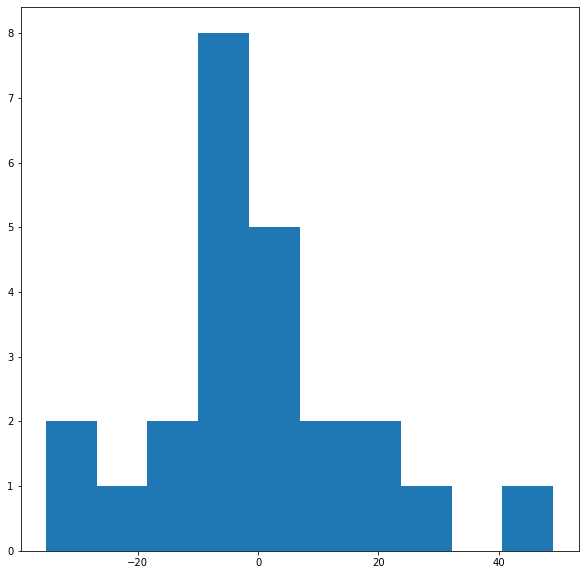

In [31]:
_ = plt.hist(residuals)

This visual is not sufficient to assess normality, so I will perform a Shapiro-Wilk test. 

In [32]:
from scipy.stats import shapiro
shapiro_test = shapiro(residuals)
print("Shapiro-Wilk test statistic: ", shapiro_test.statistic)
print("Shapiro-Wilk test result: ", shapiro_test.pvalue)
print("Errors are normally distributed" if shapiro_test.pvalue >= 0.05 else "Errors are not normally distributed")

Shapiro-Wilk test statistic:  0.9521955847740173
Shapiro-Wilk test result:  0.30209270119667053
Errors are normally distributed


# Conclusion

It is possible to predict stock prices through these macroeconomic variables, however they are not as statistically significant as lags of the stock price series. This can imply that stock prices are considerably detached from these macroeconomic variables. Inflation after a certain threshold is shown to be a significant predictor of stock prices but this is most likely because of confounding variables that affect both of them, such as interest rates. A next analysis will consider microeconomic variables, and interactions with other markets. 